# Projet 6: Classifiez automatiquement des biens de consommation

## Analyse mixte - NLP & CV.

### Sommaire

- <a href="#C2">Importation et analyse exploratoire du jeu de données</a>

- <a href="#C3">prétraitement de données textuelles</a>

- <a href="#C4">Fonctions communes: TSNE, Kmeans, ARI et présentation graphique</a>

- <a href="#C5">TF-IDF</a> 

- <a href="#C6">InceptionV3</a> 

- <a href="#C7">Combinaison: TF-IDF + InceptionV3</a>

# <a name="C2">Importation et analyse exploratoire du jeu de données</a>

# Libraries

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image as Image_PIL
import PIL

import time
import os

import cv2 #opencv pour SIFT, surf & orb

import string

import spacy

import nltk
from nltk.tokenize import wordpunct_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

import wordcloud
from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import adjusted_rand_score 
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import manifold, decomposition, metrics


# Style use.
sns.set_style('darkgrid')
plt.style.use('ggplot')

# hide warnings
import warnings
warnings.filterwarnings('ignore')

#Display setting
pd.options.display.max_columns=100

2022-07-18 15:01:16.330884: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-18 15:01:16.364951: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/houssein/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-18 15:01:16.364960: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Data

In [2]:
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [3]:
df.shape

(1050, 15)

# EDA

In [4]:
df.head(1)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."


In [5]:
def get_category_lvl(tree, level=1):
    '''this function return the category level.
    
    parameters:
        tree: the category tree for one product
        level: the level in the category tree between 1 and 3
        
    return:
        the category level asking for
    '''
    lvl = ''
    i=0
    for categ in tree[2:-2].split(sep=' >>'):
        lvl=categ
        i+=1
        if i==level:
            break
    return lvl    

In [6]:
df['category'] = df['product_category_tree'].apply(lambda x: get_category_lvl(x, level=1))

In [7]:
df.head(1)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing


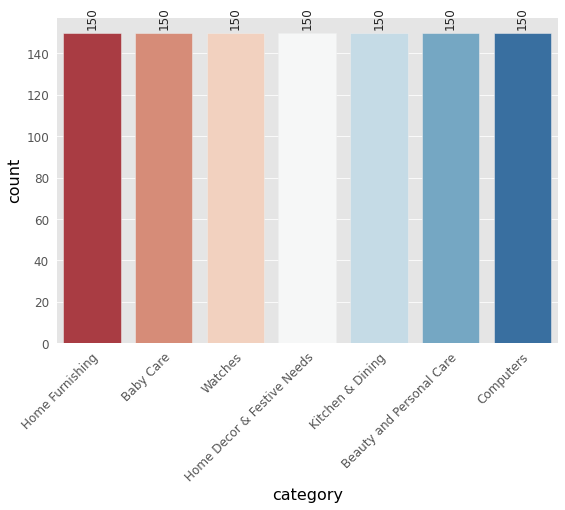

In [8]:
vbars = df['category'].value_counts().values

plt.figure(figsize=(9, 6))
sns.countplot(x='category',
              data=df,
              palette='RdBu'
             )
plt.xlabel('category', fontsize=16, c='black')
plt.xticks(fontsize=12, rotation=45, ha='right', rotation_mode='anchor')
plt.ylabel('count', fontsize=16, c='black')
plt.yticks(fontsize=12)

for i in range(7):
    plt.annotate(text=vbars[i], xy=(i, vbars[i]+3), fontsize=12, rotation=90, ha='center')

plt.show()

In [9]:
data = df[['category', 'description', 'image']]

In [10]:
data.head(1)

,category,description,image
0,Home Furnishing,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg


# <a name="C3">Prétraitement de données textuelles</a>

## <a name="C31">Preprocessing</a> 

In [11]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')', '.,']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

data['description_bow'] = data['description'].apply(lambda x : transform_bow_fct(x))
data['description_bow_lem'] = data['description'].apply(lambda x : transform_bow_lem_fct(x))
data['description_dl'] = data['description'].apply(lambda x : transform_dl_fct(x))
data.shape

(1050, 6)

# <a name="C4">Fonctions communes: TSNE, Kmeans, ARI et présentation graphique</a>

In [12]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features, classifier = KMeans) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, 
                init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = classifier(n_clusters=num_labels)
    cls.fit(X_tsne)
    ARI = np.round(adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(21, 9))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categories")
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

In [13]:
l_cat = list(set(data['category']))
print("catégories : ", l_cat)
y_cat_num = [(6-l_cat.index(data.iloc[i]['category'])) for i in range(len(data))]
print(len(y_cat_num))
print(set(y_cat_num))

catégories :  ['Computers', 'Home Furnishing', 'Kitchen & Dining', 'Home Decor & Festive Needs', 'Baby Care', 'Beauty and Personal Care', 'Watches']
1050
{0, 1, 2, 3, 4, 5, 6}


# <a name="C5">TF-IDF</a>

##  <a name="C51">Préparation sentences</a> 

In [14]:
vectorizer_tfidf = TfidfVectorizer(max_df=0.95, min_df=1)
X_tfidf = vectorizer_tfidf.fit_transform(data['description_bow'])
X_tfidf.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

##  <a name="C52">Exécution du modèle</a>

In [15]:
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(X_tfidf)

Tf-idf : 
--------
ARI :  0.5195 time :  3.0


##  <a name="C53">Visualisation</a>

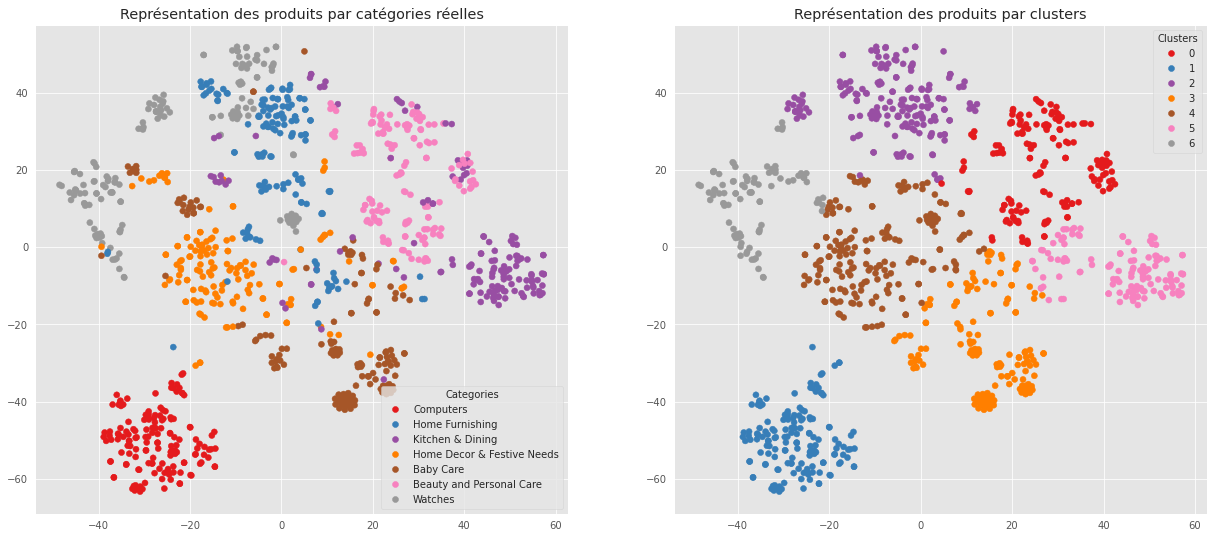

ARI :  0.5195


In [16]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

---
# <a name="C6">InceptionV3</a> 

---
## Fonction pour redimensionner les images

In [17]:
def resize_sq_fill_image(img, sq_size=224, fill_col=(255,255,255),
                 interpolation=Image_PIL.ANTIALIAS):
    '''
    this function takes an image, resizes the image and fills the non existing space
    with custom color

    Argumants:
        img: image in np or PIL format
    
        sq_size: size request
    
        fill_col: fill color request
    
    returns:
        new_img: image resized with fill color
    '''    
    # can be PIL.Image.Image or np.array
    #if type(img) == np.ndarray:
    #    img = Image_PIL.fromarray(img)
    #elif type(img) == PIL.Image.Image:
    #    pass
    #else:
    #    print("ERROR: image format unknown, please give np.array or PIL.Image.Image")
    # PIL.Image.Image format from here

    w, h = img.size
    if h != w:
        dif = h if h > w else w
        new_img = Image_PIL.new('RGB', (dif, dif), fill_col)
        new_img.paste(img, (int((dif - w) / 2), int((dif - h) / 2)))
        img = new_img
    
    # Change format to np.array and resize with cv2
    new_img = cv2.resize(np.asarray(img), (sq_size, sq_size), interpolation)
    return np.array(new_img)

---
## Créations des Features de chaque image via CNN InceptionV3

* Pour chaque image resize en 299x299 pixel, passage en array et reshape en (1, 299, 299, 3)
* Extraction du dernier vecteur (1, 2048), avant le dernier étape du model VGG16: la classification (un vecteur à 1000 éléments)

In [18]:
# example of using the InceptionV3 model as a feature extraction model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model

from sklearn import cluster, metrics
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



# identification of key points and associated descriptors

descriptors = []
temps1=time.time()

# load the model
model = InceptionV3()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# get the feature vectors
data_set = {}
path = 'Images/'
list_photos = [file for file in os.listdir('Images')]
for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    # load an image from file and convert the image size to 299x299 pixels
    img_path = path+data['image'][data['image'].index==image_num].values[0]
    img = image.load_img(img_path)#, target_size=(299, 299))
    img = resize_sq_fill_image(img, sq_size=299)

    # convert the image pixels to a numpy array
    img = img_to_array(img)
    # reshape data for the model
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    # prepare the image for the VGG model
    img = preprocess_input(img)
    # get extracted features
    features = model.predict(img, verbose=0)
    data_set[data['image'][data['image'].index==image_num].values[0]]=features


# get a list of the filenames
filenames = np.array(list(data_set.keys()))

# get a list of just the features
feat = np.array(list(data_set.values()))

# reshape so that there are 1050 samples of 4096 vectors
feat = feat.reshape(-1,2048)

    

print()
print("Number of features : ", feat.shape)

duration1=time.time()-temps1
print("treatment times for InceptionV3 features extraction : ", "%15.2f" % duration1, "secondes")

2022-07-18 15:01:23.809230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/houssein/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-07-18 15:01:23.809253: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-18 15:01:23.809273: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: houssein-Vostro-15-7510
2022-07-18 15:01:23.809277: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: houssein-Vostro-15-7510
2022-07-18 15:01:23.809344: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-07-18 15:01:23.809366: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel report

0
100
200
300
400
500
600
700
800
900
1000

Number of features :  (1050, 2048)
treatment times for InceptionV3 features extraction :            83.67 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [19]:
# reduce the amount of dimensions in the feature vector

print("features dimensions before PCA : ", feat.shape)

#pca = PCA(n_components=70, random_state=22)
pca = decomposition.PCA(n_components=0.99, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

print("features dimensions after PCA : ", x.shape)

features dimensions before PCA :  (1050, 2048)
features dimensions after PCA :  (1050, 688)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [20]:
%%time
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(x)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category"]
print(df_tsne.shape)

(1050, 3)
CPU times: user 43.1 s, sys: 356 ms, total: 43.5 s
Wall time: 2.77 s


## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE et calcul ARI de similarité catégories images / clusters

In [21]:
cls = KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

labels = data["category"]
print("ARI : ", "%6.4f" % metrics.adjusted_rand_score(labels, cls.labels_))

(1050, 4)
ARI :  0.5551


## Analyse visuelle : affichage T-SNE selon catégories d'images et selon clusters

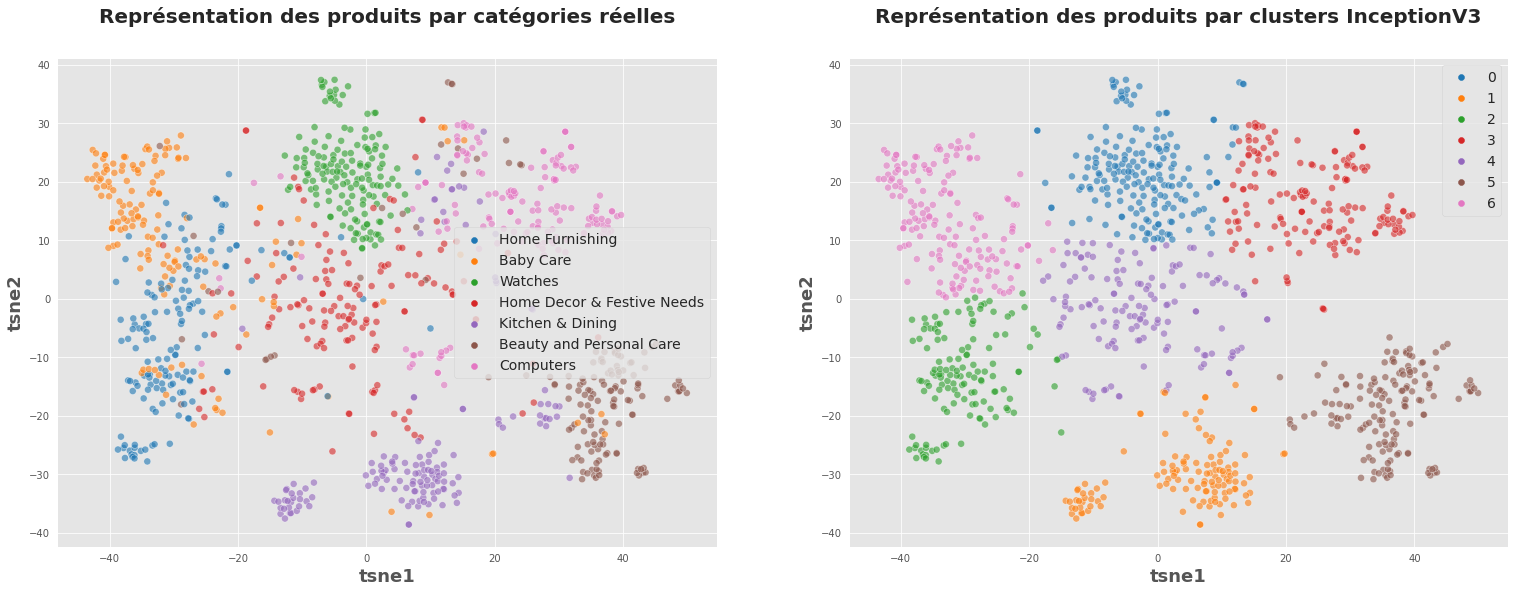

ARI InceptionV3 :  0.5551


In [22]:
plt.figure(figsize=(26,9))

plt.subplot(1,2,1)
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('Représentation des produits par catégories réelles', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 18, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 18, fontweight = 'bold')
plt.legend(prop={'size': 14}) 


plt.subplot(1,2,2)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('Représentation des produits par clusters InceptionV3', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 18, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 18, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["category"]
print("ARI InceptionV3 : ", "%6.4f" % metrics.adjusted_rand_score(labels, cls.labels_))

---
# <a name="C7">Combinaison: Tf-Idf + InceptionV3</a> 

In [26]:
feat.shape# features of InceptionV3 model before PCA

(1050, 2048)

In [23]:
x.shape # features of InceptionV3 model after PCA

(1050, 688)

In [24]:
x

array([[ 0.4927922 , -0.52914214, -2.0259824 , ..., -0.02511349,
         0.07564527,  0.11004023],
       [-1.7051464 , -0.5109813 , -3.2402964 , ..., -0.29436374,
        -0.21551412,  0.12958501],
       [-1.3537807 , -0.7711046 , -4.2297616 , ..., -0.03813909,
        -0.13738473, -0.08935474],
       ...,
       [ 0.17319538, -1.0583335 , -2.4172177 , ..., -0.09600917,
        -0.01909416,  0.00929169],
       [ 4.222032  , -2.3894956 , -0.68128294, ...,  0.03284354,
         0.17417815, -0.1007917 ],
       [ 6.5467334 , -2.2825546 , -0.7598453 , ...,  0.10917817,
        -0.1888974 , -0.09174843]], dtype=float32)

In [27]:
X_tfidf.shape # features of tfidf

(1050, 5892)

In [28]:
X_tfidf

<1050x5892 sparse matrix of type '<class 'numpy.float64'>'
	with 37640 stored elements in Compressed Sparse Row format>

In [29]:
type(x)

numpy.ndarray

In [30]:
type(feat)

numpy.ndarray

In [31]:
type(X_tfidf)

scipy.sparse.csr.csr_matrix

In [33]:
feat.shape[1]+X_tfidf.shape[1]

7940

In [39]:
matrix = X_tfidf.todense()

In [40]:
x_combined = np.hstack([matrix, feat])

In [41]:
x_combined.shape

(1050, 7940)

## Réductions de dimension

In [63]:
# reduce the amount of dimensions in the feature vector

print("features dimensions before PCA : ", x_combined.shape)

#pca = PCA(n_components=70, random_state=22)
pca = decomposition.PCA(n_components=0.9, random_state=22)
pca.fit(x_combined)
x = pca.transform(x_combined)

print("features dimensions after PCA : ", x.shape)

features dimensions before PCA :  (1050, 7940)
features dimensions after PCA :  (1050, 285)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [64]:
%%time
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(x)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["category"]
print(df_tsne.shape)

(1050, 3)
CPU times: user 52.1 s, sys: 450 ms, total: 52.5 s
Wall time: 3.39 s


## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE et calcul ARI de similarité catégories images / clusters

In [65]:
cls = KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

labels = data["category"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

(1050, 4)
ARI :  0.5901281083834301


## Analyse visuelle : affichage T-SNE selon catégories d'images et selon clusters

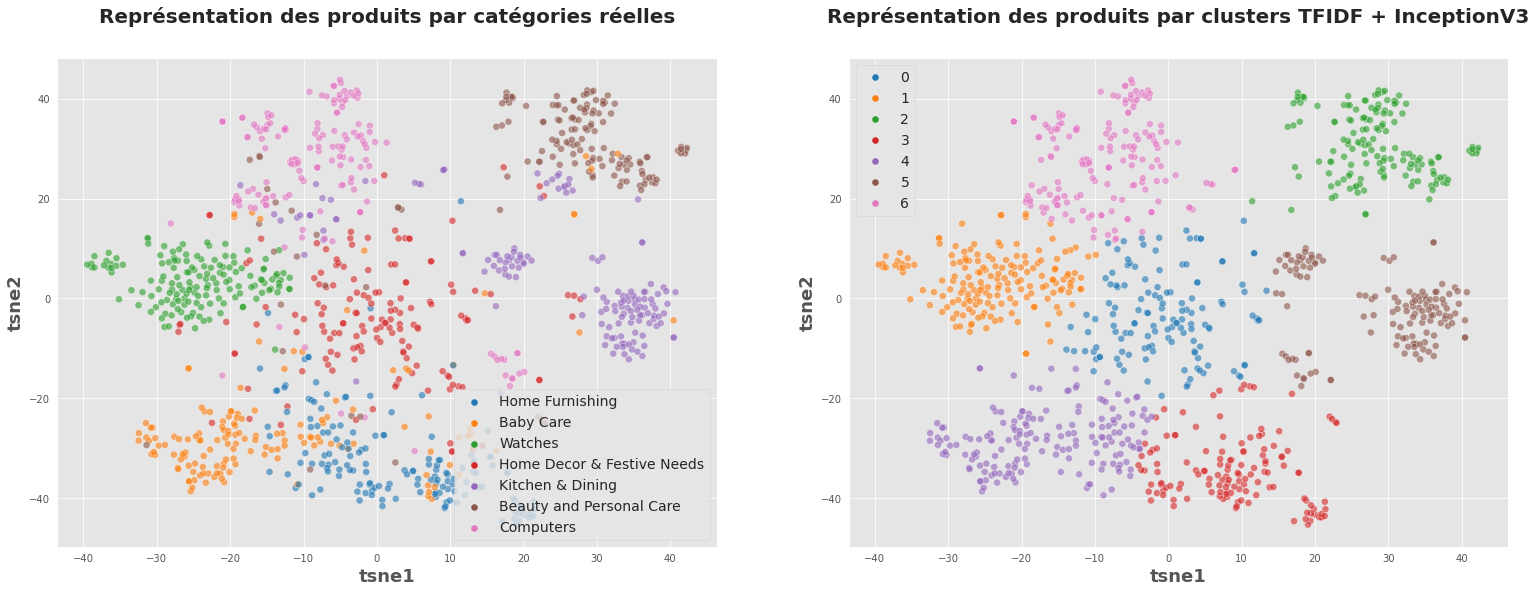

ARI TF-IDF + InceptionV3 :  0.5901


In [66]:
plt.figure(figsize=(26,9))

plt.subplot(1,2,1)
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('Représentation des produits par catégories réelles', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 18, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 18, fontweight = 'bold')
plt.legend(prop={'size': 14}) 


plt.subplot(1,2,2)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('Représentation des produits par clusters TFIDF + InceptionV3',
          fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 18, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 18, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["category"]
print("ARI TF-IDF + InceptionV3 : ", "%6.4f" % metrics.adjusted_rand_score(labels, cls.labels_))

# Fin